In [ ]:
# Install necessary packages; repeat only if you get ImportError later
!pip install pandas folium xmltodict matplotlib seaborn missingno

import pandas as pd
import folium
from folium.plugins import MarkerCluster, HeatMap
import matplotlib.pyplot as plt
import xmltodict
from google.colab import files
import seaborn as sns
import missingno as msno


In [ ]:
# Upload your XML AQI dataset
uploaded = files.upload()
xml_file = list(uploaded.keys())[0]

# Read and parse the XML content
with open(xml_file, 'r', encoding='utf-8') as f:
    xml_content = f.read()
data_dict = xmltodict.parse(xml_content)

def extract_aqi_entries(xml_dict):
    records = []
    for state in xml_dict['AqIndex']['Country']['State']:
        state_name = state['@id']
        if 'City' not in state:
            continue
        cities = state['City']
        if isinstance(cities, dict):
            cities = [cities]
        for city in cities:
            city_name = city['@id']
            if 'Station' not in city:
                continue
            stations = city['Station']
            if isinstance(stations, dict):
                stations = [stations]
            for station in stations:
                latitude = station.get('@latitude')
                longitude = station.get('@longitude')
                aqi_value = None
                if 'Air_Quality_Index' in station:
                    aqi_info = station['Air_Quality_Index']
                    if isinstance(aqi_info, list):
                        aqi_info = aqi_info[0]
                    aqi_value = aqi_info.get('@Value')
                if aqi_value is not None:
                    try:
                        aqi_value = int(aqi_value)
                    except ValueError:
                        continue
                else:
                    continue
                records.append({
                    'City': city_name,
                    'State': state_name,
                    'Latitude': latitude,
                    'Longitude': longitude,
                    'AQI': aqi_value
                })
    return pd.DataFrame(records)

df = extract_aqi_entries(data_dict)
df.to_csv('india_aqi.csv', index=False)
df.head()


Saving data_aqi_cpcb.xml to data_aqi_cpcb.xml


City           State    Latitude   Longitude  AQI
0          Anantapur  Andhra_Pradesh   14.675886   77.593027   29
1           Chittoor  Andhra_Pradesh   13.204880   79.097889   35
2             Kadapa  Andhra_Pradesh   14.465052   78.824187   37
3  Rajamahendravaram  Andhra_Pradesh  16.9872867  81.7363176   58
4           Tirupati  Andhra_Pradesh       13.67       79.35   49

In [ ]:
# Reload data from saved CSV (optional if needed)
df = pd.read_csv('india_aqi.csv')
df.head()


City           State   Latitude  Longitude  AQI
0          Anantapur  Andhra_Pradesh  14.675886  77.593027   29
1           Chittoor  Andhra_Pradesh  13.204880  79.097889   35
2             Kadapa  Andhra_Pradesh  14.465052  78.824187   37
3  Rajamahendravaram  Andhra_Pradesh  16.987287  81.736318   58
4           Tirupati  Andhra_Pradesh  13.670000  79.350000   49

In [ ]:
# Dataset shape, structure, summary
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.info()
df.describe(include='all')


Rows: 454, Columns: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       454 non-null    object 
 1   State      454 non-null    object 
 2   Latitude   454 non-null    float64
 3   Longitude  454 non-null    float64
 4   AQI        454 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 17.9+ KB


City        State    Latitude   Longitude         AQI
count     454          454  454.000000  454.000000  454.000000
unique    244           26         NaN         NaN         NaN
top     Delhi  Maharashtra         NaN         NaN         NaN
freq       38           75         NaN         NaN         NaN
mean      NaN          NaN   22.930215   78.404208  161.555066
std       NaN          NaN    5.438531    4.725453   99.428323
min       NaN          NaN    8.514909   70.909168   15.000000
25%       NaN          NaN   19.087309   75.529954   81.000000
50%       NaN          NaN   23.827669   77.283000  137.000000
75%       NaN          NaN   27.827378   80.234985  234.750000
max       NaN          NaN   31.620000   94.636574  419.000000

In [ ]:
# Remove missing values and duplicates, fix datatypes
df = df.dropna(subset=['City', 'State', 'Latitude', 'Longitude', 'AQI'])
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df['AQI'] = df['AQI'].astype(int)
df = df.drop_duplicates(subset=['City', 'State', 'Latitude', 'Longitude'])

# Quick view of cleaned data
df.head()


City           State   Latitude  Longitude  AQI
0          Anantapur  Andhra_Pradesh  14.675886  77.593027   29
1           Chittoor  Andhra_Pradesh  13.204880  79.097889   35
2             Kadapa  Andhra_Pradesh  14.465052  78.824187   37
3  Rajamahendravaram  Andhra_Pradesh  16.987287  81.736318   58
4           Tirupati  Andhra_Pradesh  13.670000  79.350000   49

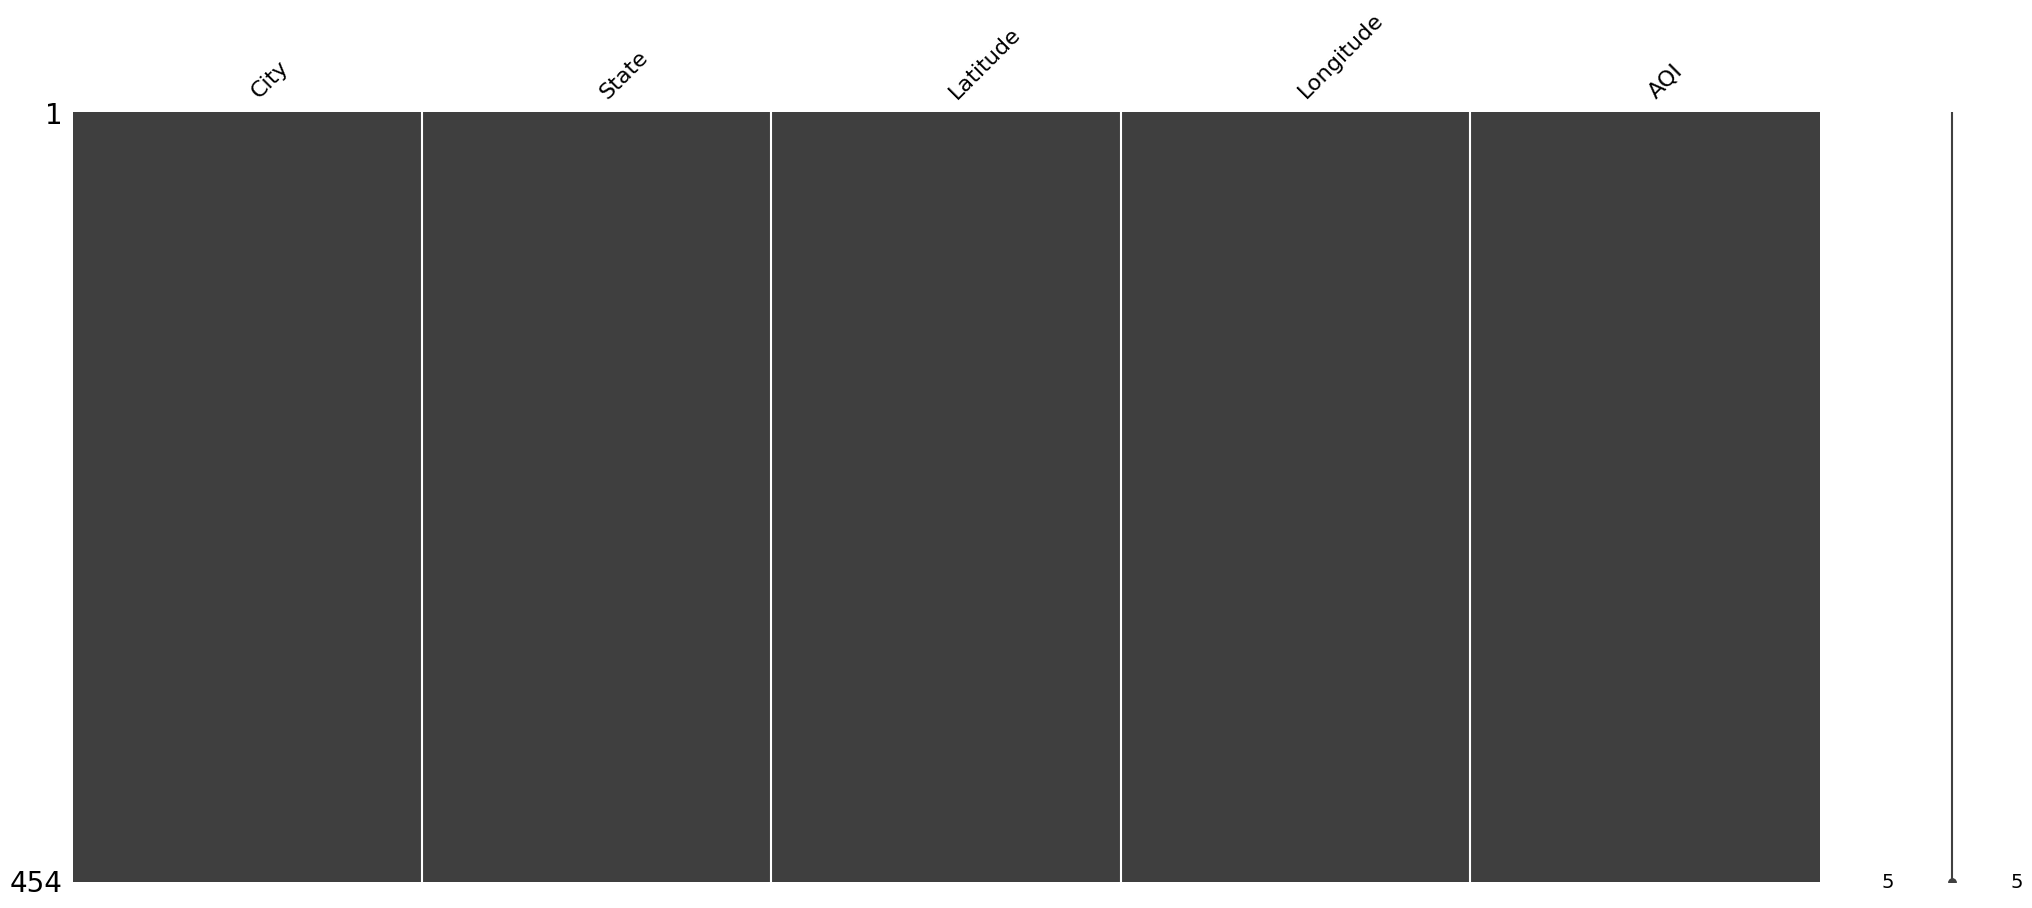

In [ ]:
# Visual check for missing values
msno.matrix(df)
plt.show()


In [ ]:
def aqi_category(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'
df['AQI_Category'] = df['AQI'].apply(aqi_category)
df.head()


City           State   Latitude  Longitude  AQI  AQI_Category
0          Anantapur  Andhra_Pradesh  14.675886  77.593027   29          Good
1           Chittoor  Andhra_Pradesh  13.204880  79.097889   35          Good
2             Kadapa  Andhra_Pradesh  14.465052  78.824187   37          Good
3  Rajamahendravaram  Andhra_Pradesh  16.987287  81.736318   58  Satisfactory
4           Tirupati  Andhra_Pradesh  13.670000  79.350000   49          Good

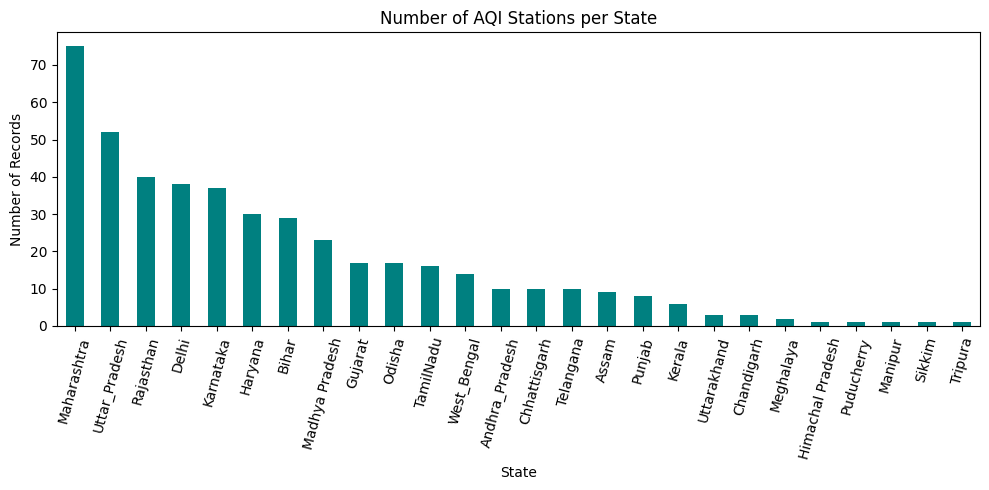

In [ ]:
# Data coverage across states
state_counts = df['State'].value_counts()
plt.figure(figsize=(10,5))
state_counts.plot(kind='bar', color='teal')
plt.title('Number of AQI Stations per State')
plt.xlabel('State')
plt.ylabel('Number of Records')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


In [ ]:
# India centered map with AQI colored circles
india_map = folium.Map(location=[22.97, 78.65], zoom_start=5)

color_dict = {
    'Good': 'green',
    'Satisfactory': 'lightgreen',
    'Moderate': 'orange',
    'Poor': 'red',
    'Very Poor': 'purple',
    'Severe': 'black'
}

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        popup=f"{row['City']}, {row['State']}<br>AQI: {row['AQI']}",
        tooltip=f"{row['City']}: AQI {row['AQI']}",
        color=color_dict[row['AQI_Category']],
        fill=True,
        fill_opacity=0.7
    ).add_to(india_map)
india_map


In [ ]:
# Map for selected AQI categories only
filtered_df = df[df['AQI_Category'].isin(['Good', 'Moderate', 'Poor'])]
filtered_map = folium.Map(location=[22.97, 78.65], zoom_start=5)
for _, row in filtered_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        popup=f"{row['City']}, {row['State']}<br>AQI: {row['AQI']}",
        tooltip=f"{row['City']}: AQI {row['AQI']}",
        color=color_dict[row['AQI_Category']],
        fill=True,
        fill_opacity=0.7
    ).add_to(filtered_map)
filtered_map


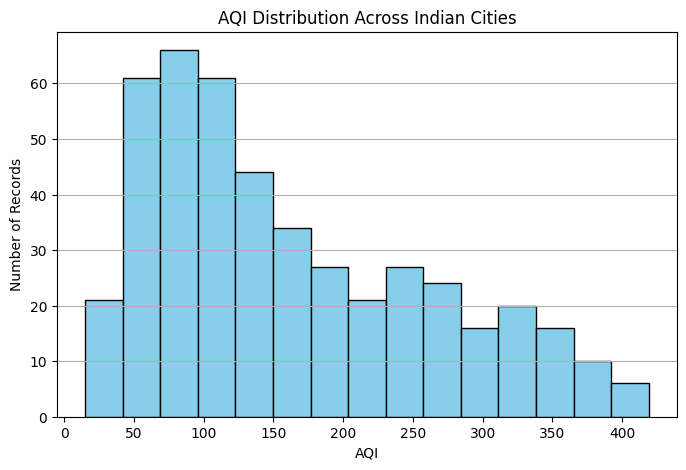

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df['AQI'], bins=15, color='skyblue', edgecolor='black')
plt.title('AQI Distribution Across Indian Cities')
plt.xlabel('AQI')
plt.ylabel('Number of Records')
plt.grid(axis='y')
plt.show()


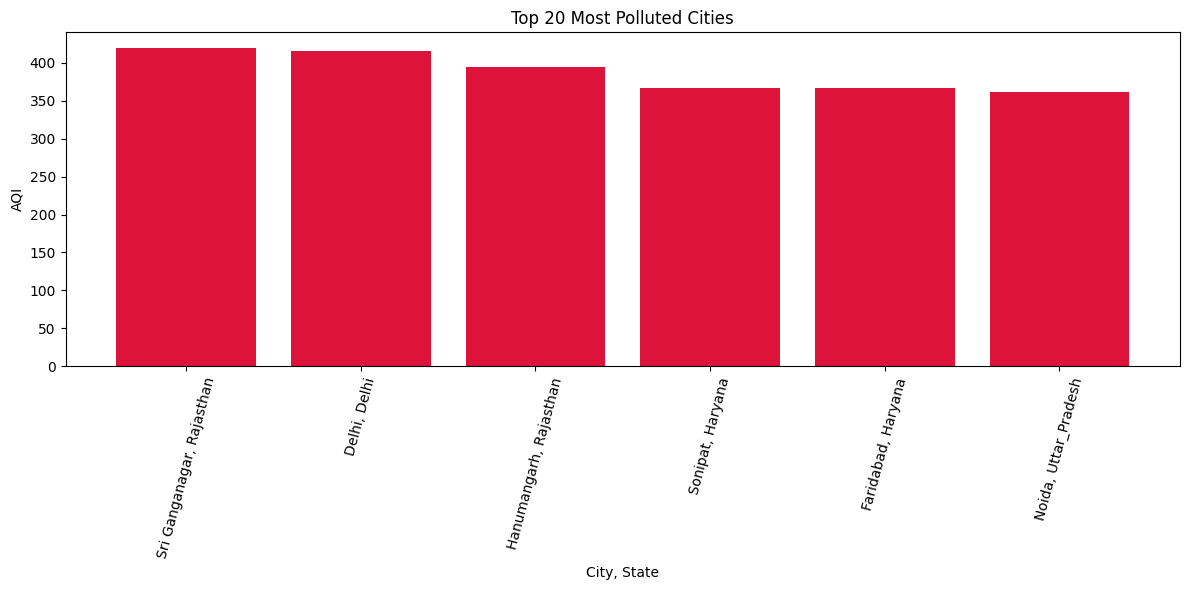

In [ ]:
top20 = df.sort_values(by='AQI', ascending=False).head(20)
plt.figure(figsize=(12,6))
plt.bar(top20['City'] + ", " + top20['State'], top20['AQI'], color='crimson')
plt.title('Top 20 Most Polluted Cities')
plt.xlabel('City, State')
plt.ylabel('AQI')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


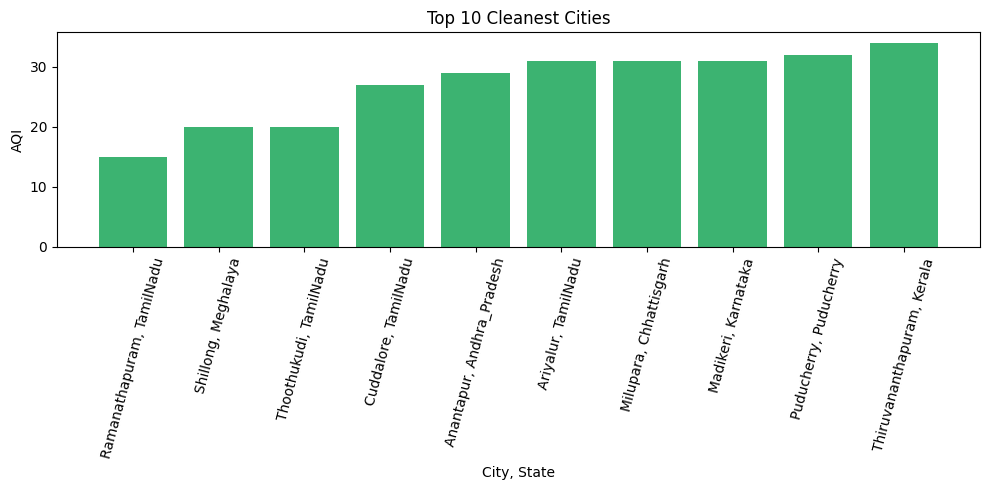

In [ ]:
top_clean = df.sort_values(by='AQI', ascending=True).head(10)
plt.figure(figsize=(10,5))
plt.bar(top_clean['City'] + ", " + top_clean['State'], top_clean['AQI'], color='mediumseagreen')
plt.title('Top 10 Cleanest Cities')
plt.xlabel('City, State')
plt.ylabel('AQI')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


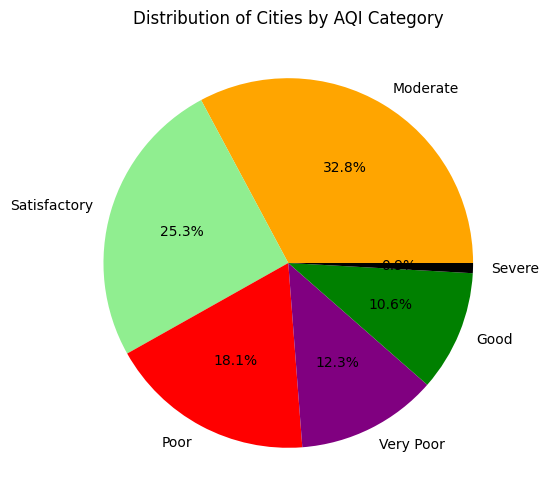

In [ ]:
cat_counts = df['AQI_Category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%',
        colors=[color_dict[c] for c in cat_counts.index])
plt.title('Distribution of Cities by AQI Category')
plt.show()


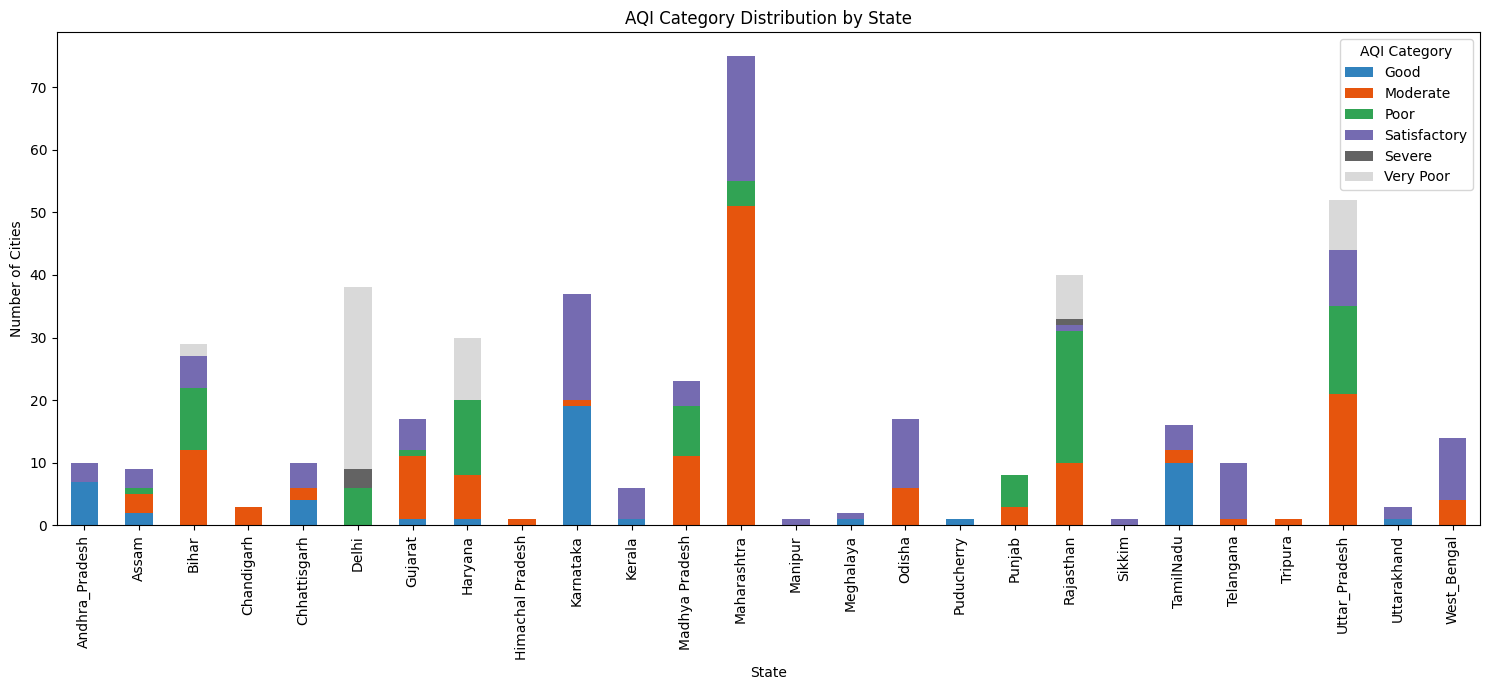

In [ ]:
cat_by_state = pd.crosstab(df['State'], df['AQI_Category'])
cat_by_state.plot(kind='bar', stacked=True, figsize=(15,7), colormap="tab20c")
plt.title('AQI Category Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Cities')
plt.legend(title='AQI Category')
plt.tight_layout()
plt.show()


In [ ]:
heat_data = df[['Latitude', 'Longitude', 'AQI']].values.tolist()
india_heatmap = folium.Map(location=[22.97, 78.65], zoom_start=5)
HeatMap(heat_data, radius=18, blur=12, max_zoom=1).add_to(india_heatmap)
india_heatmap


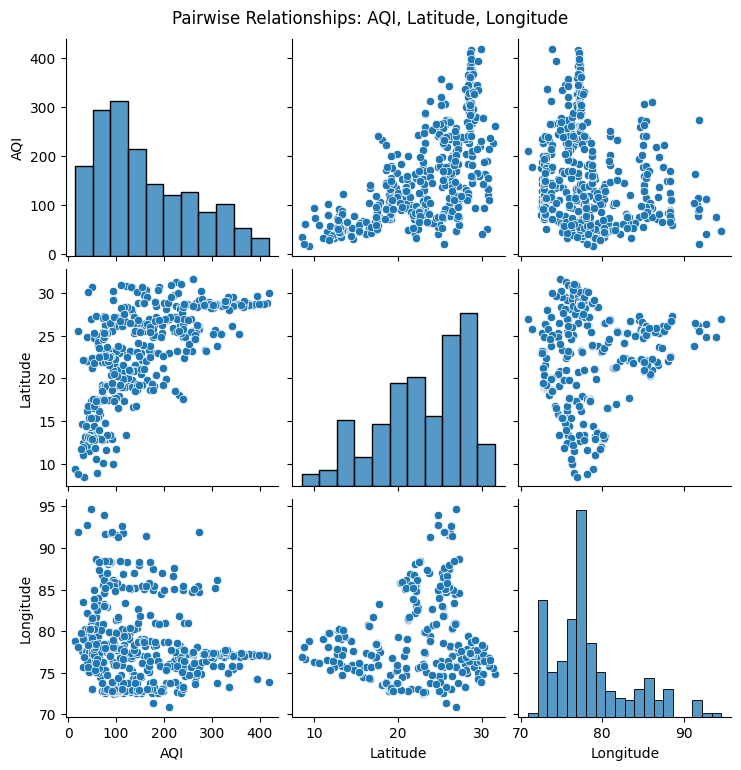

In [ ]:
sns.pairplot(df[['AQI', 'Latitude', 'Longitude']], diag_kind='hist')
plt.suptitle('Pairwise Relationships: AQI, Latitude, Longitude', y=1.02)
plt.show()


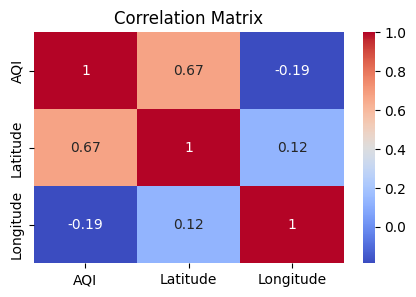

In [ ]:
corr = df[['AQI', 'Latitude', 'Longitude']].corr()
plt.figure(figsize=(5,3))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Interactive sorted table view in Colab
df.sort_values(by='AQI', ascending=False).head(20)


City          State   Latitude  Longitude  AQI AQI_Category
354  Sri Ganganagar      Rajasthan  29.931624  73.864511  419       Severe
65            Delhi          Delhi  28.776200  77.051074  416       Severe
88            Delhi          Delhi  28.674045  77.131023  410       Severe
74            Delhi          Delhi  28.732820  77.170633  402       Severe
98            Delhi          Delhi  28.699793  77.165453  398    Very Poor
329     Hanumangarh      Rajasthan  29.610750  74.283608  394    Very Poor
92            Delhi          Delhi  28.732528  77.119920  392    Very Poor
83            Delhi          Delhi  28.567890  77.250515  388    Very Poor
79            Delhi          Delhi  28.684678  77.076574  384    Very Poor
70            Delhi          Delhi  28.571027  77.071901  384    Very Poor
87            Delhi          Delhi  28.623763  77.287209  377    Very Poor
82            Delhi          Delhi  28.822836  77.101981  374    Very Poor
86            Delhi          Delhi  28.530785  77.271255  370    Very Poor
94            Delhi          Delhi  28.550425  77.215938  368    Very Poor
144         Sonipat        Haryana  29.027200  77.062100  367    Very Poor
122       Faridabad        Haryana  28.390720  77.300590  366    Very Poor
61            Delhi          Delhi  28.815329  77.153010  365    Very Poor
428           Noida  Uttar_Pradesh  28.569230  77.393848  362    Very Poor
95            Delhi          Delhi  28.710508  77.249485  362    Very Poor
62            Delhi          Delhi  28.647622  77.315809  359    Very Poor

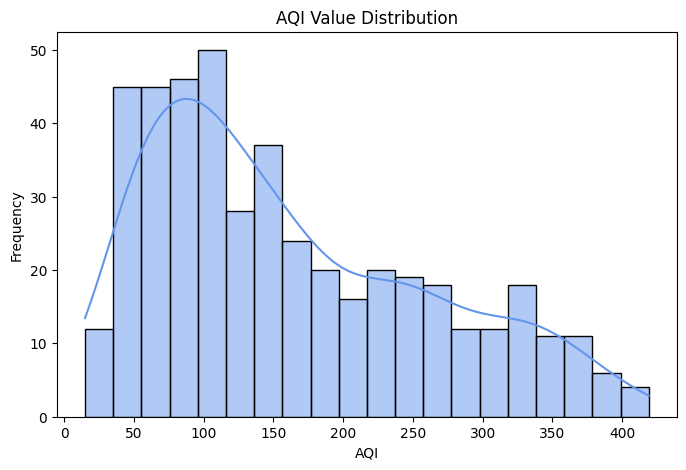

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['AQI'], bins=20, kde=True, color='cornflowerblue')
plt.title('AQI Value Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


/tmp/ipython-input-92-4185396094.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




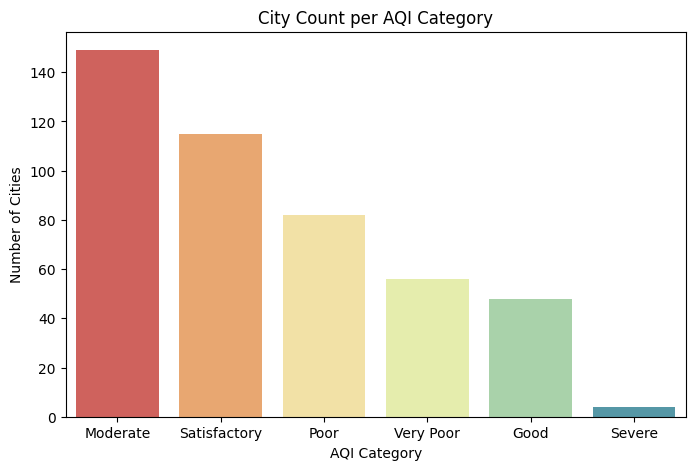

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='AQI_Category', data=df, order=df['AQI_Category'].value_counts().index, palette='Spectral')
plt.title('City Count per AQI Category')
plt.xlabel('AQI Category')
plt.ylabel('Number of Cities')
plt.show()


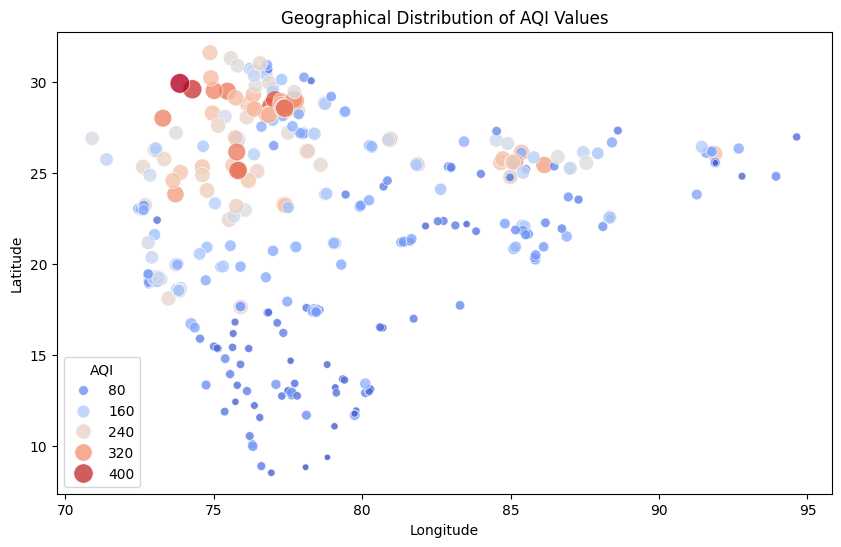

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Longitude', y='Latitude', hue='AQI', data=df, palette='coolwarm', size='AQI', sizes=(20,200), alpha=0.8, legend='brief')
plt.title('Geographical Distribution of AQI Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='AQI')
plt.show()


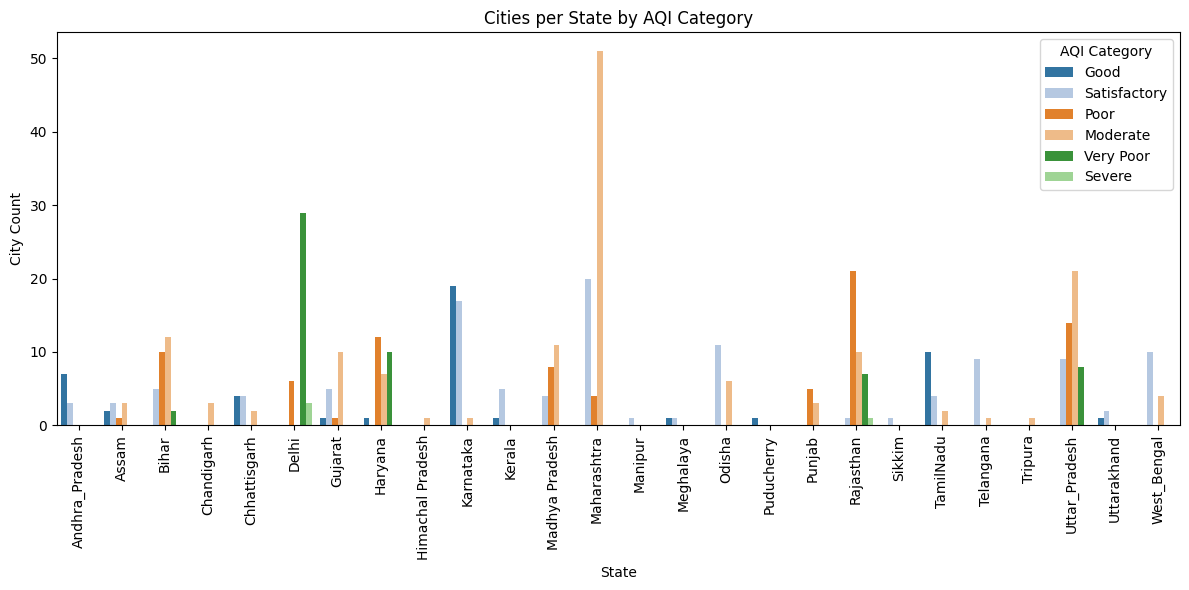

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='State', hue='AQI_Category', data=df, palette='tab20')
plt.title('Cities per State by AQI Category')
plt.xlabel('State')
plt.ylabel('City Count')
plt.xticks(rotation=90)
plt.legend(title='AQI Category')
plt.tight_layout()
plt.show()


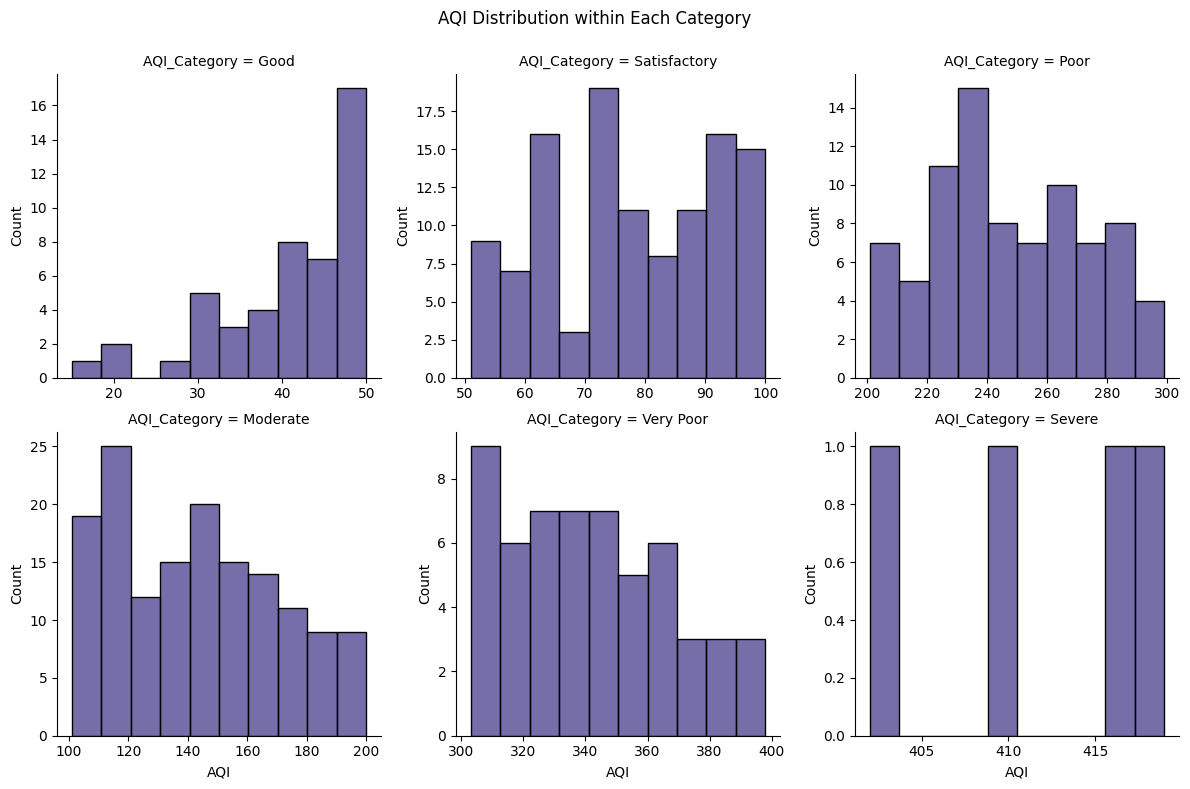

In [ ]:
g = sns.FacetGrid(df, col="AQI_Category", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "AQI", bins=10, color='darkslateblue')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('AQI Distribution within Each Category')
plt.show()


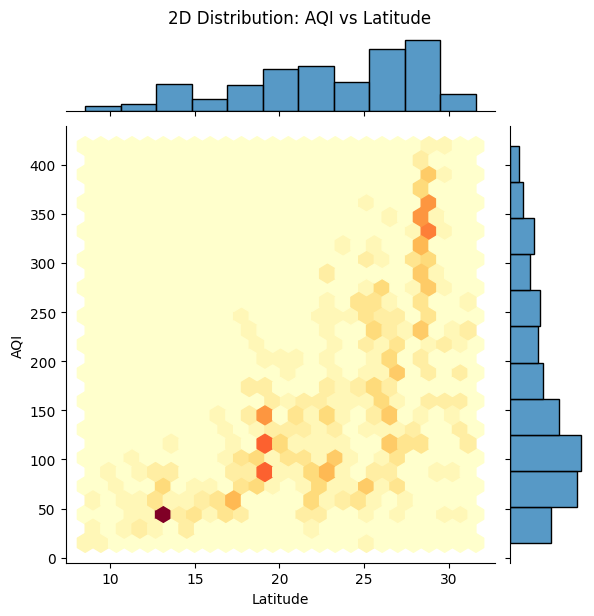

In [ ]:
sns.jointplot(x='Latitude', y='AQI', data=df, kind='hex', gridsize=25, cmap='YlOrRd')
plt.suptitle('2D Distribution: AQI vs Latitude', y=1.02)
plt.show()


/tmp/ipython-input-97-1647007166.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




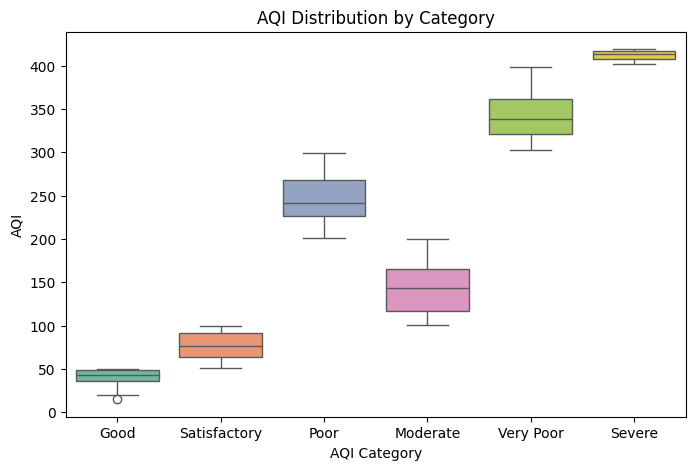

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='AQI_Category', y='AQI', data=df, palette='Set2')
plt.title('AQI Distribution by Category')
plt.xlabel('AQI Category')
plt.ylabel('AQI')
plt.show()


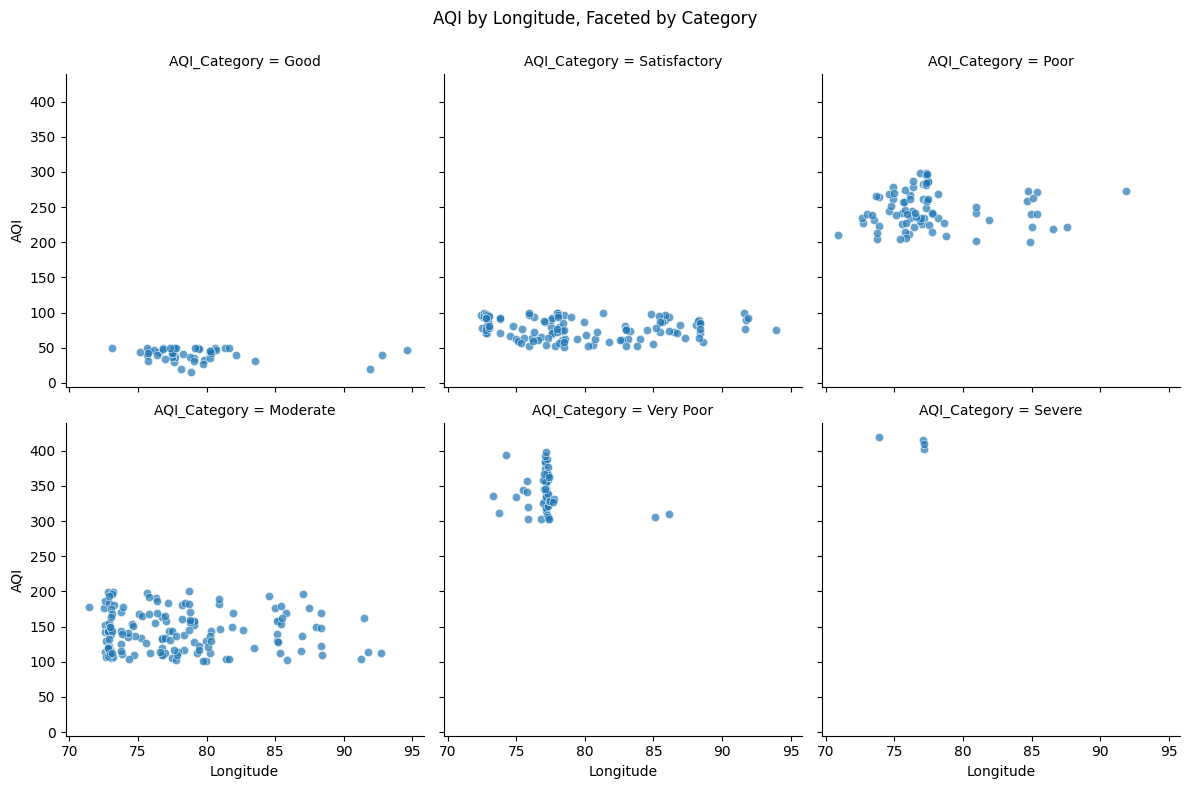

In [ ]:
g = sns.FacetGrid(df, col='AQI_Category', col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, x='Longitude', y='AQI', alpha=0.7)
g.set_axis_labels("Longitude", "AQI")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('AQI by Longitude, Faceted by Category')
plt.show()


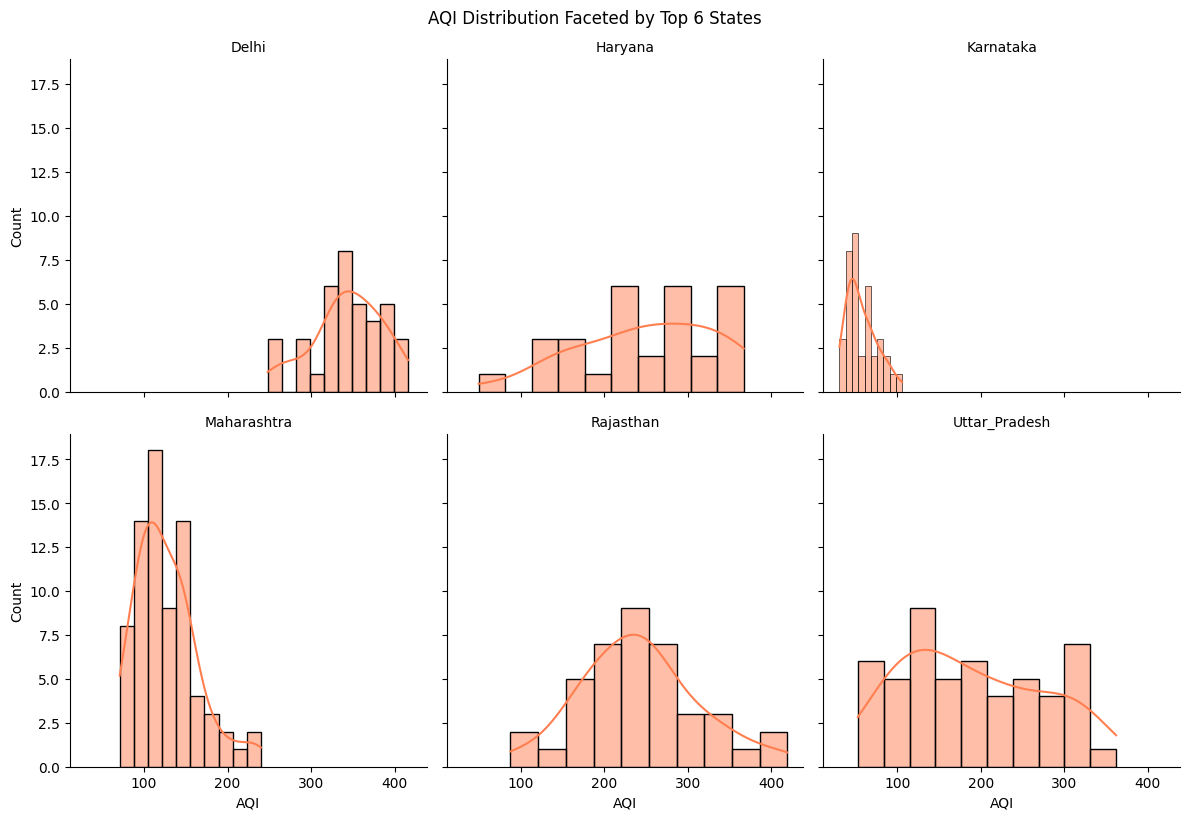

In [ ]:
top_states = df['State'].value_counts().head(6).index.tolist()
df_facet = df[df['State'].isin(top_states)]
g = sns.FacetGrid(df_facet, col="State", col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='AQI', bins=10, kde=True, color='coral')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('AQI Distribution Faceted by Top 6 States', y=1.02)
plt.show()


In [ ]:
# Installs for Dash, Plotly, pyngrok (may take 1-2 minutes)
!pip install dash dash-bootstrap-components plotly pyngrok


In [ ]:
import pandas as pd

df = pd.read_csv('india_aqi.csv')
# If not yet categorized, add the AQI category column:
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'
df['AQI_Category'] = df['AQI'].apply(aqi_category)


In [ ]:
import dash
from dash import html, dcc, dash_table
import plotly.express as px

# AQI Color Map (for consistency)
color_dict = {
    'Good': 'green',
    'Satisfactory': 'lightgreen',
    'Moderate': 'orange',
    'Poor': 'red',
    'Very Poor': 'purple',
    'Severe': 'black'
}

# Create a map figure using Plotly
fig_map = px.scatter_mapbox(
    df, lat="Latitude", lon="Longitude", color="AQI_Category", size="AQI",
    hover_name="City", hover_data=["State","AQI"],
    color_discrete_map=color_dict,
    mapbox_style="carto-positron", zoom=4, height=420,
    title="Indian Cities AQI Map"
)

# Histogram
fig_hist = px.histogram(df, x="AQI", nbins=20, color="AQI_Category", title="AQI Value Distribution")

# Pie chart
fig_pie = px.pie(df, names="AQI_Category", title="City Count by AQI Category", color="AQI_Category", color_discrete_map=color_dict)

# Dash Layout
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H2("Indian Cities AQI Dashboard (via Dash & Plotly)"),
    dcc.Tabs([
        dcc.Tab(label='Map', children=[dcc.Graph(figure=fig_map)]),
        dcc.Tab(label='Histogram', children=[dcc.Graph(figure=fig_hist)]),
        dcc.Tab(label='Pie Chart', children=[dcc.Graph(figure=fig_pie)]),
        dcc.Tab(label='Table', children=[
            dash_table.DataTable(
                data=df.sort_values(by='AQI', ascending=False).to_dict('records'),
                columns=[{"name": i, "id": i} for i in df.columns],
                page_size=15,
                style_table={'overflowX': 'auto'},
                style_cell={'textAlign': 'left', 'padding': '4px'},
                style_header={'backgroundColor': 'lightgray', 'fontWeight': 'bold'}
            )
        ])
    ])
])


In [ ]:
import plotly.express as px

color_dict = {
    'Good': 'green',
    'Satisfactory': 'lightgreen',
    'Moderate': 'orange',
    'Poor': 'red',
    'Very Poor': 'purple',
    'Severe': 'black'
}

fig = px.scatter_mapbox(
    df, lat="Latitude", lon="Longitude", color="AQI_Category", size="AQI",
    hover_name="City", hover_data=["State","AQI"],
    color_discrete_map=color_dict,
    mapbox_style="carto-positron", zoom=4, height=420,
    title="Indian Cities AQI Map"
)
fig.show()


In [ ]:
import threading

def run_dash():
    app.run(host="0.0.0.0", debug=False)

thread = threading.Thread(target=run_dash)
thread.start()


In [ ]:
import plotly.express as px

# Interactive scatter map
px.scatter_mapbox(
    df, lat="Latitude", lon="Longitude", color="AQI_Category", size="AQI",
    hover_name="City", hover_data=["State","AQI"],
    color_discrete_map=color_dict,
    mapbox_style="carto-positron", zoom=4, height=420, title="AQI Map"
).show()


<IPython.core.display.Javascript object>

DATASET SUMMARY:
         City        State    Latitude   Longitude         AQI AQI_Category
count     454          454  454.000000  454.000000  454.000000          454
unique    244           26         NaN         NaN         NaN            6
top     Delhi  Maharashtra         NaN         NaN         NaN     Moderate
freq       38           75         NaN         NaN         NaN          149
mean      NaN          NaN   22.930215   78.404208  161.555066          NaN
std       NaN          NaN    5.438531    4.725453   99.428323          NaN
min       NaN          NaN    8.514909   70.909168   15.000000          NaN
25%       NaN          NaN   19.087309   75.529954   81.000000          NaN
50%       NaN          NaN   23.827669   77.283000  137.000000          NaN
75%       NaN          NaN   27.827378   80.234985  234.750000          NaN
max       NaN          NaN   31.620000   94.636574  419.000000          NaN

Rows: 454, Columns: 6
Columns: ['City', 'State', 'Latitude', 'Longitud

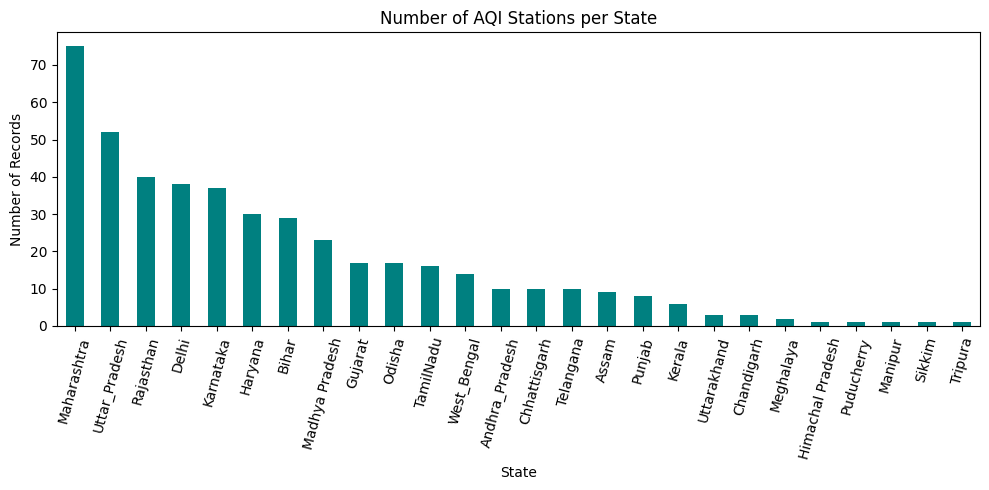

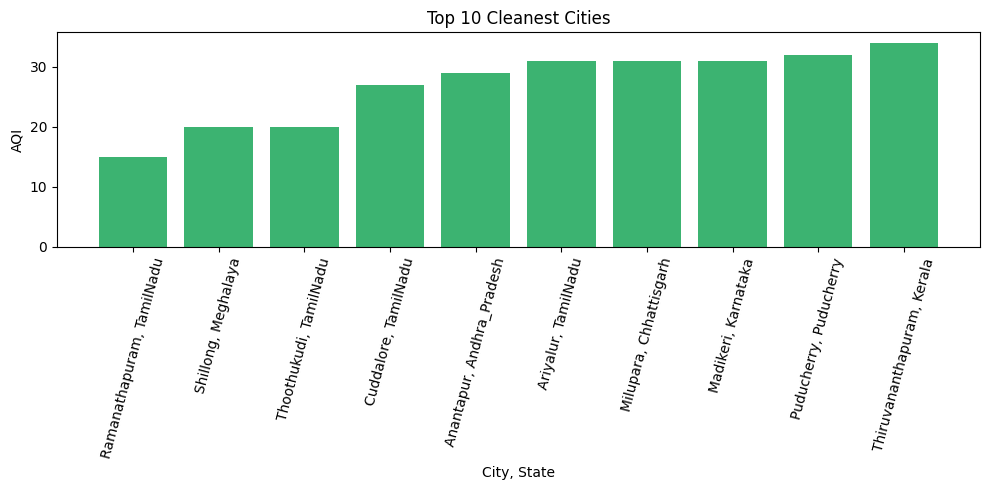

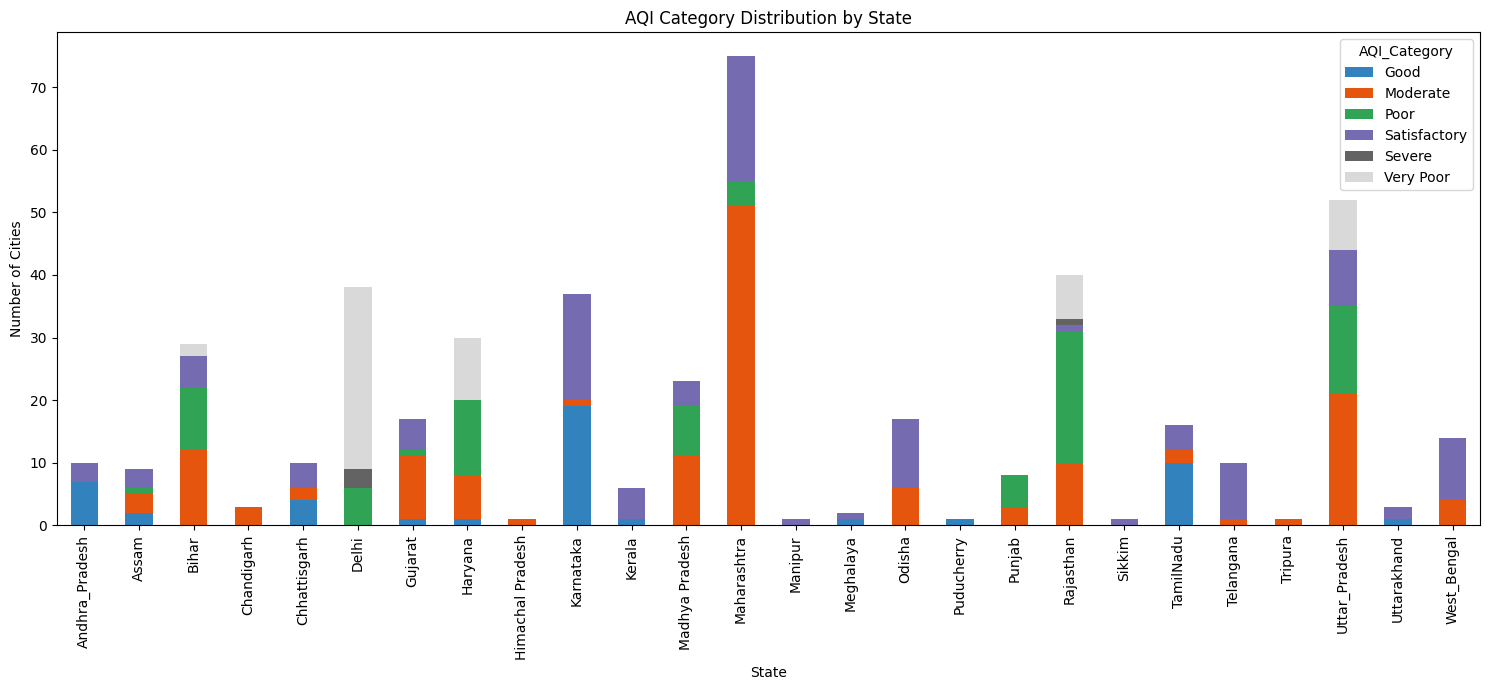

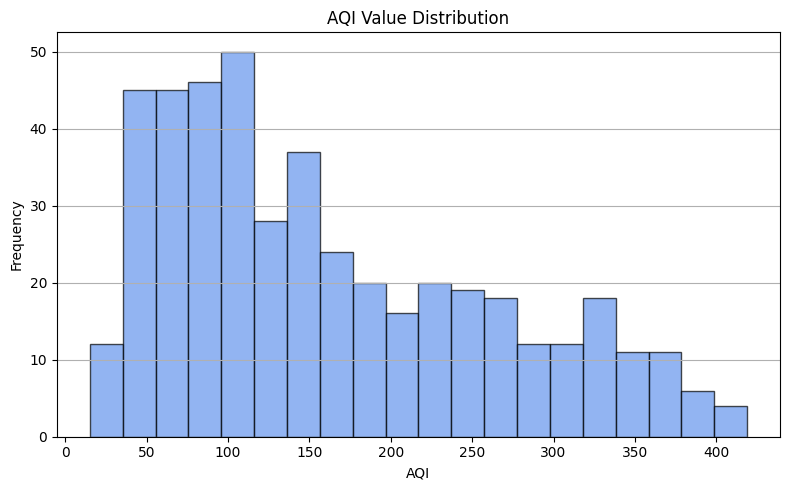

/tmp/ipython-input-106-4169078641.py:80: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




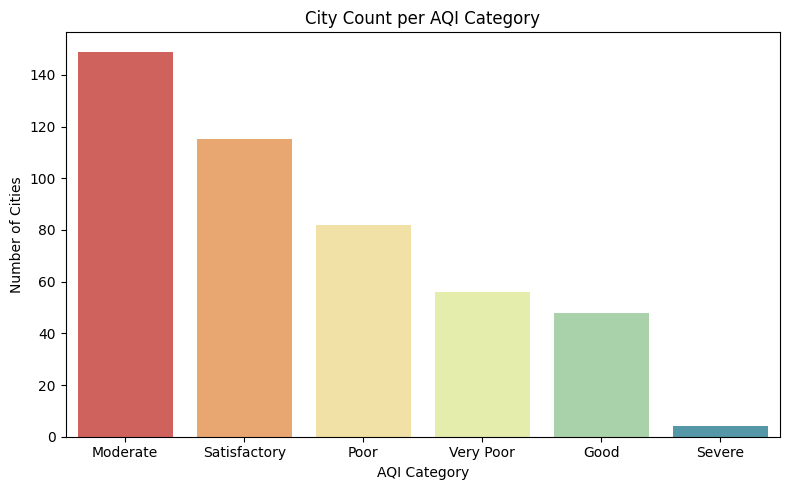

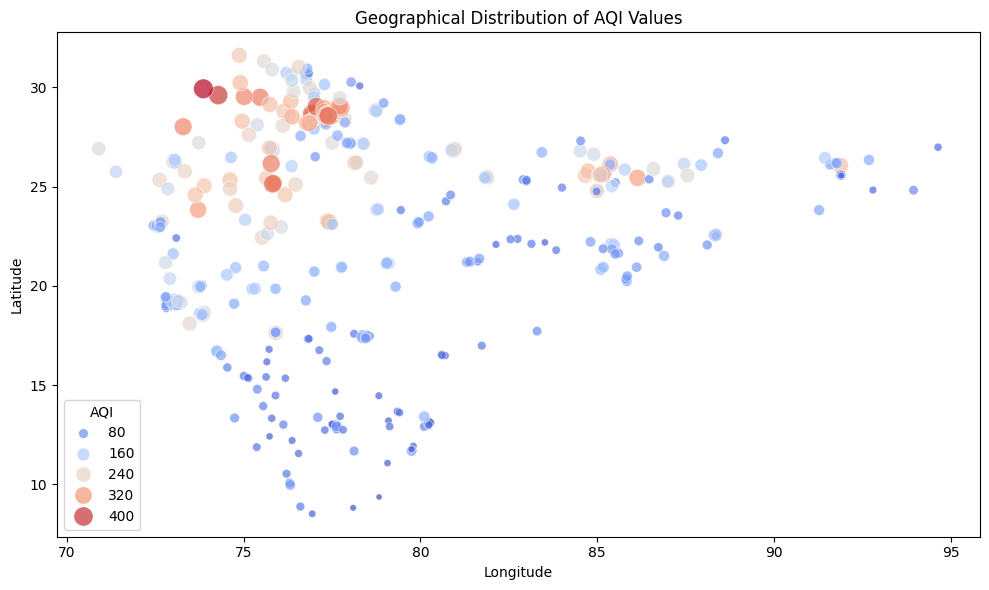

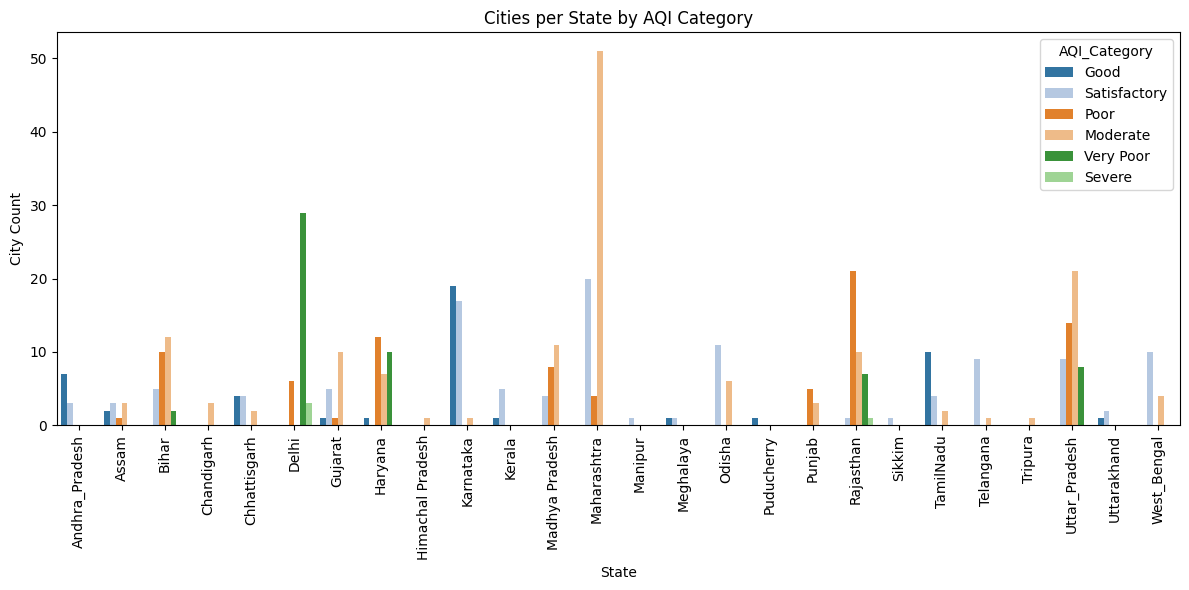

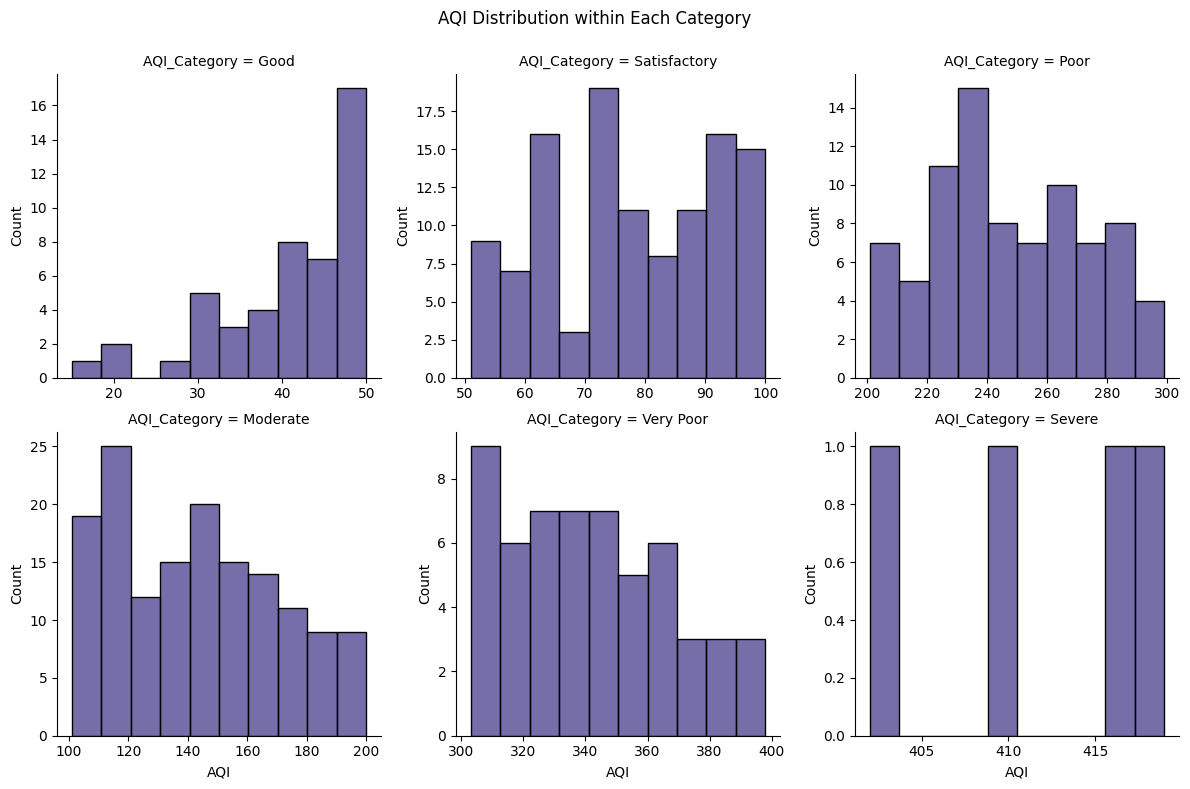

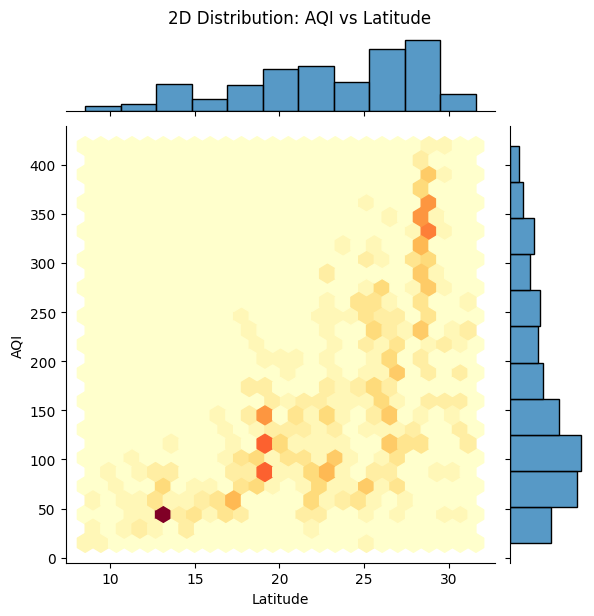

/tmp/ipython-input-106-4169078641.py:125: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




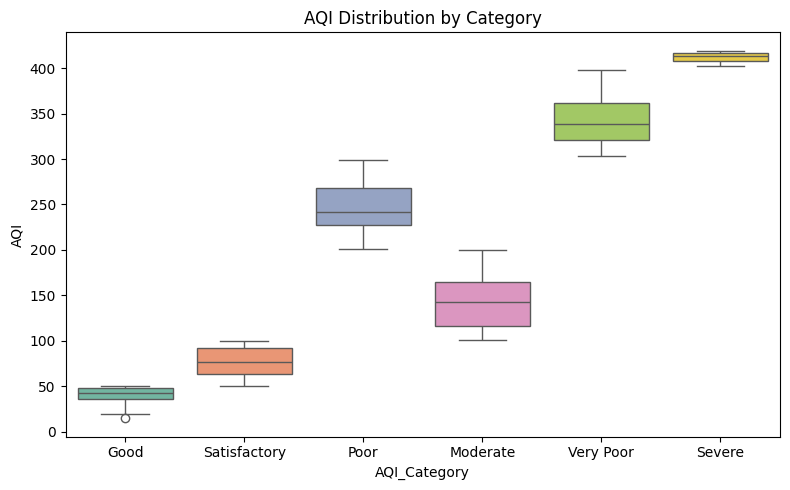

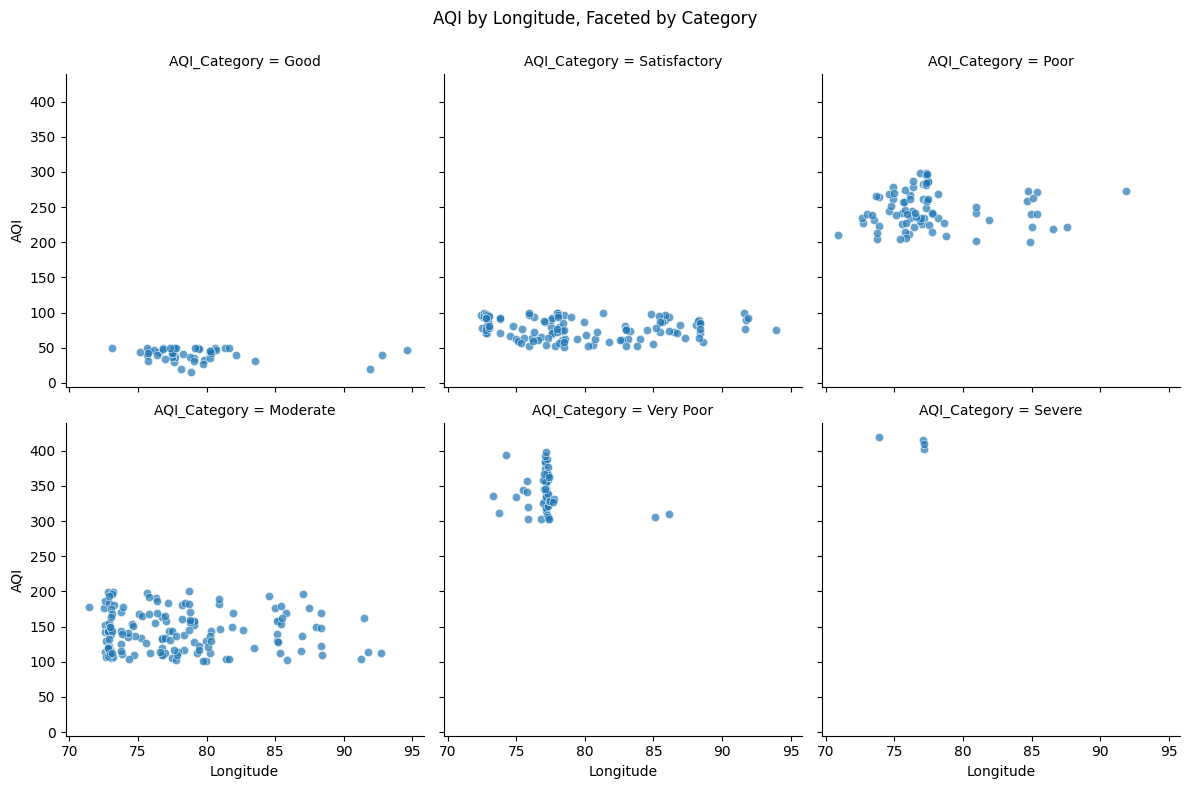

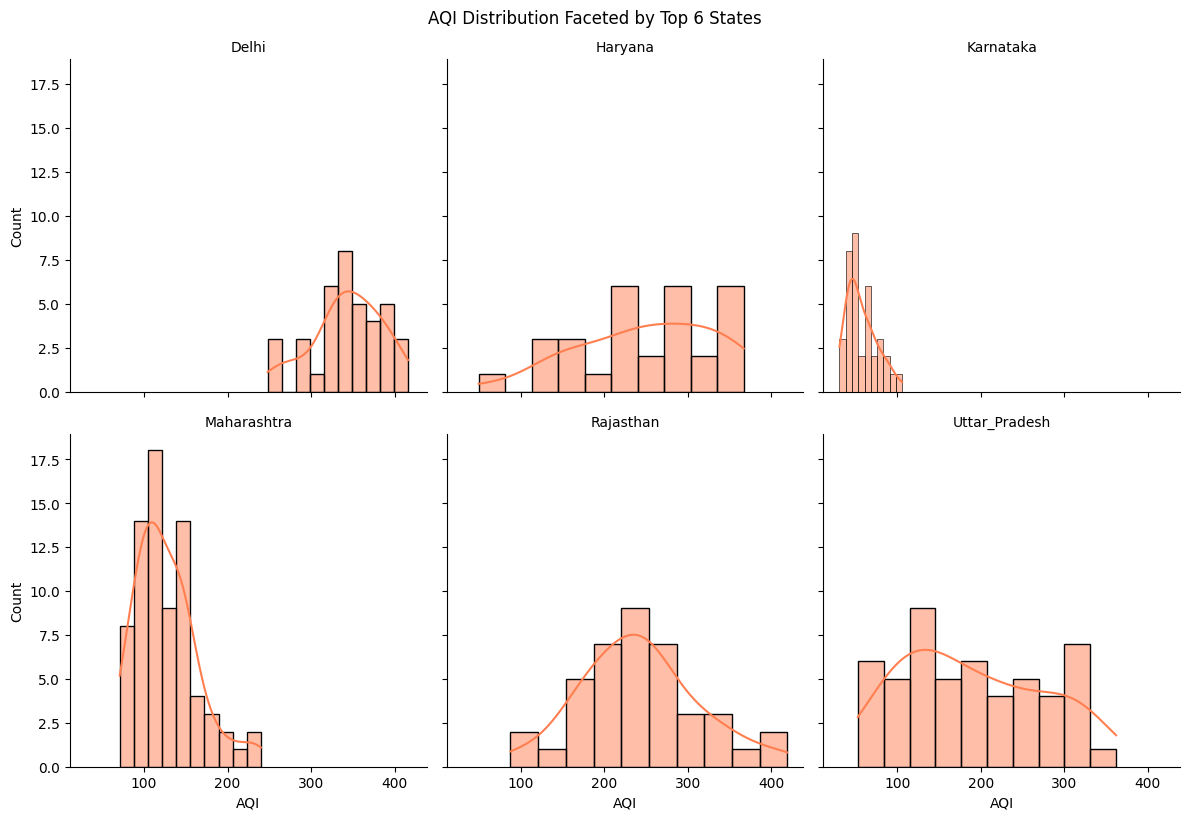

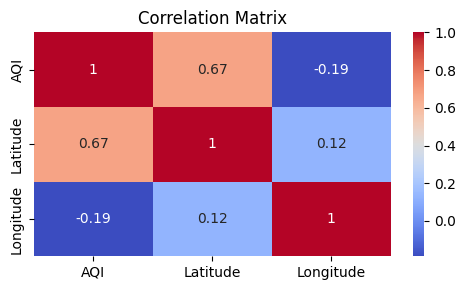

Folium AQI map saved as 'india_aqi_map.html'.
Folium AQI heatmap saved as 'india_aqi_heatmap.html'.
\nAll charts saved as PNG images. Both folium maps saved as HTML and can be downloaded for sharing or embedding.


In [ ]:
# --- FINAL VISUALIZATION AND EXPORT CELL ---

# Required imports
!pip install folium --quiet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Load your dataset (ensure india_aqi.csv exists from previous steps!)
df = pd.read_csv('india_aqi.csv')

# Ensure AQI_Category column exists
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'
if 'AQI_Category' not in df.columns:
    df['AQI_Category'] = df['AQI'].apply(aqi_category)

color_dict = {'Good': 'green','Satisfactory': 'lightgreen','Moderate': 'orange',
              'Poor': 'red','Very Poor': 'purple','Severe': 'black'}

# --- Dataset summary info (prints, not image) ---
print("DATASET SUMMARY:")
print(df.describe(include='all'))
print(f"\nRows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Columns: {list(df.columns)}\n")

# --- Visual 1: Records Per State (Bar Plot)
plt.figure(figsize=(10,5))
df['State'].value_counts().plot(kind='bar', color='teal')
plt.title('Number of AQI Stations per State')
plt.xlabel('State')
plt.ylabel('Number of Records')
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig('records_per_state.png')
plt.show()

# --- Visual 2: Top 10 Cleanest Cities
top_clean = df.sort_values(by='AQI').head(10)
plt.figure(figsize=(10,5))
plt.bar(top_clean['City'] + ", " + top_clean['State'], top_clean['AQI'], color='mediumseagreen')
plt.title('Top 10 Cleanest Cities')
plt.xlabel('City, State')
plt.ylabel('AQI')
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig('top_cleanest_cities.png')
plt.show()

# --- Visual 3: AQI Category Distribution by State
plt.figure(figsize=(15,7))
pd.crosstab(df['State'], df['AQI_Category']).plot(kind='bar', stacked=True, colormap="tab20c", ax=plt.gca())
plt.title('AQI Category Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Cities')
plt.tight_layout()
plt.savefig('aqi_category_distribution_state.png')
plt.show()

# --- Visual 4: AQI Distribution Histogram
plt.figure(figsize=(8,5))
plt.hist(df['AQI'], bins=20, color='cornflowerblue', edgecolor='black', alpha=0.7)
plt.title('AQI Value Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('aqi_histogram.png')
plt.show()

# --- Visual 5: City Count per AQI Category (Countplot)
plt.figure(figsize=(8,5))
sns.countplot(x='AQI_Category', data=df, order=df['AQI_Category'].value_counts().index, palette='Spectral')
plt.title('City Count per AQI Category')
plt.xlabel('AQI Category')
plt.ylabel('Number of Cities')
plt.tight_layout()
plt.savefig('city_count_aqi_category.png')
plt.show()

# --- Visual 6: Geo scatter (Longitude vs Latitude, hue=AQI)
plt.figure(figsize=(10,6))
sns.scatterplot(x='Longitude', y='Latitude', hue='AQI', data=df, palette='coolwarm', size='AQI', sizes=(20,200), alpha=0.7, legend='brief')
plt.title('Geographical Distribution of AQI Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('geo_scatter_aqi.png')
plt.show()

# --- Visual 7: State vs AQI Category (2D Categorical)
plt.figure(figsize=(12,6))
sns.countplot(x='State', hue='AQI_Category', data=df, palette='tab20')
plt.title('Cities per State by AQI Category')
plt.xlabel('State')
plt.ylabel('City Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('state_vs_aqi_cat.png')
plt.show()

# --- Visual 8: Faceted AQI Histogram by AQI Category
g = sns.FacetGrid(df, col="AQI_Category", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "AQI", bins=10, color='darkslateblue')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('AQI Distribution within Each Category')
g.savefig('facet_aqi_category_distribution.png')
plt.show()

# --- Visual 9: Jointplot (AQI vs Latitude)
jp = sns.jointplot(x='Latitude', y='AQI', data=df, kind='hex', gridsize=25, cmap='YlOrRd')
jp.fig.suptitle('2D Distribution: AQI vs Latitude', y=1.02)
jp.savefig('joint_lat_aqi.png')
plt.show()

# --- Visual 10: Boxplot AQI by Category
plt.figure(figsize=(8,5))
sns.boxplot(x='AQI_Category', y='AQI', data=df, palette='Set2')
plt.title('AQI Distribution by Category')
plt.tight_layout()
plt.savefig('boxplot_aqi_category.png')
plt.show()

# --- Visual 11: Faceted Scatterplot AQI by Longitude and Category
fg = sns.FacetGrid(df, col='AQI_Category', col_wrap=3, height=4)
fg.map_dataframe(sns.scatterplot, x='Longitude', y='AQI', alpha=0.7)
fg.set_axis_labels("Longitude", "AQI")
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('AQI by Longitude, Faceted by Category')
fg.savefig('facet_scatter_aqi_long.png')
plt.show()

# --- Visual 12: Statewise Distributions (FacetGrid top 6 states)
top_states = df['State'].value_counts().head(6).index.tolist()
df_facet = df[df['State'].isin(top_states)]
g = sns.FacetGrid(df_facet, col="State", col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='AQI', bins=10, kde=True, color='coral')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('AQI Distribution Faceted by Top 6 States', y=1.02)
g.savefig('facet_aqi_by_state.png')
plt.show()

# --- Visual 13: Correlation Matrix Heatmap
plt.figure(figsize=(5,3))
sns.heatmap(df[['AQI', 'Latitude', 'Longitude']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# --- Visual 14: Folium AQI Marker Map (Saves to HTML)
india_map = folium.Map(location=[22.97, 78.65], zoom_start=5)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        popup=f"{row['City']}, {row['State']}<br>AQI: {row['AQI']}",
        tooltip=f"{row['City']}: AQI {row['AQI']}",
        color=color_dict[row['AQI_Category']],
        fill=True,
        fill_opacity=0.7
    ).add_to(india_map)
india_map.save('india_aqi_map.html')
print("Folium AQI map saved as 'india_aqi_map.html'.")

# --- Visual 15: Folium Heatmap (Saves to HTML)
heat_data = df[['Latitude', 'Longitude', 'AQI']].values.tolist()
india_heatmap = folium.Map(location=[22.97, 78.65], zoom_start=5)
HeatMap(heat_data, radius=18, blur=12, max_zoom=1).add_to(india_heatmap)
india_heatmap.save('india_aqi_heatmap.html')
print("Folium AQI heatmap saved as 'india_aqi_heatmap.html'.")

print("\\nAll charts saved as PNG images. Both folium maps saved as HTML and can be downloaded for sharing or embedding.")


In [ ]:

from plotly.subplots import make_subplots
import plotly.graph_objs as go

# ... Assume df, cat_counts, color_dict already defined above ...

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "xy"}, {"type": "domain"}]],  # <-- THIS LINE IS KEY
    subplot_titles=("AQI Value Distribution", "Cities by AQI Category")
)

# Histogram in the first subplot
fig.add_trace(
    go.Histogram(x=df['AQI'], nbinsx=20, name='AQI', marker=dict(color='skyblue'), opacity=0.8),
    row=1, col=1
)

# Pie chart in the second subplot
cat_counts = df['AQI_Category'].value_counts()
fig.add_trace(
    go.Pie(
        labels=cat_counts.index,
        values=cat_counts.values,
        marker=dict(colors=[color_dict[c] for c in cat_counts.index]),
        hole=0.3
    ),
    row=1, col=2
)

fig.update_layout(height=400, title_text="AQI Distribution & Category Share")
fig.show()


In [ ]:
# --- FINAL DASHBOARD CELL FOR AQI PROJECT IN COLAB ---

# 1. Install Plotly (skip if already installed)
!pip install plotly --quiet

# 2. Imports
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from IPython.display import display, Markdown

# 3. Load Data
df = pd.read_csv('india_aqi.csv')

# 4. Add AQI_Category if needed
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'
if 'AQI_Category' not in df.columns:
    df['AQI_Category'] = df['AQI'].apply(aqi_category)

color_dict = {
    'Good': 'green', 'Satisfactory': 'lightgreen', 'Moderate': 'orange',
    'Poor': 'red', 'Very Poor': 'purple', 'Severe': 'black'
}

# --- TOP KPIs ---
total_cities = df['City'].nunique()
avg_aqi = df['AQI'].mean()
worst_row = df.loc[df['AQI'].idxmax()]
best_row = df.loc[df['AQI'].idxmin()]

display(Markdown(f"""
## <span style="color:#008080;">Project AQI Dashboard</span>
**Cities:** {total_cities}
**States:** {df['State'].nunique()}
**Average AQI:** <span style='color:orange;font-weight:bold'>{avg_aqi:.1f}</span>
**Most Polluted:** <span style='color:red'>{worst_row['City']} ({worst_row['State']}): AQI {worst_row['AQI']}</span>
**Cleanest:** <span style='color:green'>{best_row['City']} ({best_row['State']}): AQI {best_row['AQI']}</span>
"""))

# --- 1. INTERACTIVE AQI MAP (Plotly) ---
fig_map = px.scatter_mapbox(
    df, lat="Latitude", lon="Longitude", color="AQI_Category", size="AQI",
    hover_name="City", hover_data=["State","AQI"],
    color_discrete_map=color_dict,
    mapbox_style="carto-positron", zoom=4, height=400,
    title="Indian Cities: AQI Map by Category"
)
fig_map.show()

# --- 2. AQI HISTOGRAM & CATEGORY PIE CHART ---
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "xy"}, {"type": "domain"}]],  # histogram + pie in grid
    subplot_titles=("AQI Value Distribution", "Cities by AQI Category")
)

fig.add_trace(
    go.Histogram(x=df['AQI'], nbinsx=20, name='AQI', marker=dict(color='skyblue'), opacity=0.8),
    row=1, col=1
)

cat_counts = df['AQI_Category'].value_counts()
fig.add_trace(
    go.Pie(
        labels=cat_counts.index,
        values=cat_counts.values,
        marker=dict(colors=[color_dict[c] for c in cat_counts.index]),
        hole=0.3
    ),
    row=1, col=2
)
fig.update_layout(height=400, title_text="AQI Distribution & Category Share")
fig.show()

# --- 3. TOP/BOTTOM CITIES BAR CHARTS ---
top10 = df.nlargest(10, 'AQI')
bot10 = df.nsmallest(10, 'AQI')

fig2 = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Top 10 Most Polluted Cities", "Top 10 Cleanest Cities")
)
fig2.add_trace(go.Bar(
    x=top10['City'] + '-' + top10['State'],
    y=top10['AQI'],
    marker=dict(color='crimson')
), row=1, col=1)
fig2.add_trace(go.Bar(
    x=bot10['City'] + '-' + bot10['State'],
    y=bot10['AQI'],
    marker=dict(color='forestgreen')
), row=1, col=2)
fig2.update_layout(height=400, title_text="City Rankings by AQI")
fig2.update_xaxes(tickangle=60)
fig2.show()

# --- 4. STATEWISE AQI CATEGORY DISTRIBUTION (STACKED BAR) ---
catby = pd.crosstab(df['State'], df['AQI_Category'])
catby = catby.loc[catby.sum(axis=1).sort_values(ascending=False).index]  # Sort by state size

fig3 = go.Figure()
for category in catby.columns:
    fig3.add_trace(go.Bar(
        name=category,
        x=catby.index,
        y=catby[category],
        marker_color=color_dict[category]
    ))
fig3.update_layout(
    barmode='stack',
    title='AQI Category Distribution by State',
    xaxis_title='State',
    yaxis_title='City Count',
    height=500
)
fig3.update_xaxes(tickangle=60)
fig3.show()

# --- Optional: Dashboard note
display(Markdown("""
*Dashboard sections:
- KPIs
- Interactive AQI map
- Distribution & share
- Top/bottom 10 cities
- Statewise category breakdown*

*Interact with plots: Zoom, hover, or export as PNG for slides.*
"""))



## <span style="color:#008080;">Project AQI Dashboard</span>
**Cities:** 244  
**States:** 26  
**Average AQI:** <span style='color:orange;font-weight:bold'>161.6</span>  
**Most Polluted:** <span style='color:red'>Sri Ganganagar (Rajasthan): AQI 419</span>  
**Cleanest:** <span style='color:green'>Ramanathapuram (TamilNadu): AQI 15</span>



*Dashboard sections:  
- KPIs  
- Interactive AQI map  
- Distribution & share  
- Top/bottom 10 cities  
- Statewise category breakdown*

*Interact with plots: Zoom, hover, or export as PNG for slides.*


In [ ]:
# Install streamlit and dependencies
!pip install streamlit pandas plotly
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pandas plotly pyngrok


In [ ]:
# main.ipynb
!pip install streamlit pandas plotly pyngrok
!apt-get install nodejs npm -y  # For localtunnel if needed
!npm install -g localtunnel


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js
  libjs-inherits libjs-is-typedarray libjs-psl libjs-source-map
  libjs-sprintf-js libjs-typedarray-to-buffer libnode-dev libnode72
  libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy
  node-are-we-there-yet node-argparse node-arrify node-asap node-asynckit
  node-balanced-match node-brace-expansion node-builtins node-cacache
  node-chalk node-chownr node-clean-yaml-object node-cli-table node-clone
  node-color-convert node-color-name node-colors node-columnify
  node-combined-stream node-commander node-console-control-strings
  node-copy-concurrently node-core-util-is node-coveralls node-cssom
  node-cssstyle node-debug node-decompress-response node-defaults
  node-delayed-st

In [ ]:
# main.ipynb
from google.colab import files
files.upload()  # Select your 'india_aqi.csv' file to upload


Saving india_aqi.csv to india_aqi.csv


{'india_aqi.csv': b'City,State,Latitude,Longitude,AQI\nAnantapur,Andhra_Pradesh,14.675886,77.593027,29\nChittoor,Andhra_Pradesh,13.204880,79.097889,35\nKadapa,Andhra_Pradesh,14.465052,78.824187,37\nRajamahendravaram,Andhra_Pradesh,16.9872867,81.7363176,58\nTirupati,Andhra_Pradesh,13.67,79.35,49\nTirupati,Andhra_Pradesh,13.615387,79.409230,48\nVijayawada,Andhra_Pradesh,16.536107,80.594233,50\nVijayawada,Andhra_Pradesh,16.486692,80.699436,47\nVijayawada,Andhra_Pradesh,16.509717,80.612222,54\nVisakhapatnam,Andhra_Pradesh,17.72,83.3,74\nByrnihat,Assam,26.071318,91.87488,273\nGuwahati,Assam,26.2028636,91.70046436,77\nGuwahati,Assam,26.10887,91.589544,99\nGuwahati,Assam,26.187500,91.744194,89\nGuwahati,Assam,26.181742,91.78063,114\nNagaon,Assam,26.349082,92.68449,112\nNalbari,Assam,26.446912,91.439057,162\nSilchar,Assam,24.82827,92.79525,40\nSivasagar,Assam,26.987634,94.636574,47\nAraria,Bihar,26.146529,87.454184,177\nArrah,Bihar,25.5626095,84.663264,259\nBegusarai,Bihar,25.444266,86.140169,

In [ ]:
# main.ipynb
app_code = '''
import streamlit as st
import pandas as pd
import plotly.express as px

@st.cache_data
def load_data():
    df = pd.read_csv('india_aqi.csv')
    def aqi_category(aqi):
        if aqi <= 50: return 'Good'
        elif aqi <= 100: return 'Satisfactory'
        elif aqi <= 200: return 'Moderate'
        elif aqi <= 300: return 'Poor'
        elif aqi <= 400: return 'Very Poor'
        else: return 'Severe'
    if 'AQI_Category' not in df.columns:
        df['AQI_Category'] = df['AQI'].apply(aqi_category)
    return df

df = load_data()

st.title("Air Quality Index (AQI) Dashboard - Indian Cities")

# Scrollable data table with pagination
st.subheader("AQI Data Table")
rows_per_page = 10
total_rows = len(df)
pages = (total_rows // rows_per_page) + 1
page_number = st.number_input("Page Number", min_value=1, max_value=pages, value=1, step=1)
start_idx = (page_number - 1) * rows_per_page
end_idx = start_idx + rows_per_page
st.dataframe(df.iloc[start_idx:end_idx, :], height=300)

st.subheader("Dashboard Visualizations")

color_dict = {
    'Good': 'green',
    'Satisfactory': 'lightgreen',
    'Moderate': 'orange',
    'Poor': 'red',
    'Very Poor': 'purple',
    'Severe': 'black'
}

# KPIs
total_cities = df['City'].nunique()
avg_aqi = df['AQI'].mean()
worst_city = df.loc[df['AQI'].idxmax()]
cleanest_city = df.loc[df['AQI'].idxmin()]

col1, col2, col3 = st.columns(3)
col1.metric("Total Cities", total_cities)
col2.metric("Average AQI", f"{avg_aqi:.1f}")
col3.metric("Most Polluted City", f"{worst_city['City']} ({worst_city['AQI']})")
st.write(f"**Cleanest City:** {cleanest_city['City']} ({cleanest_city['AQI']})")

# Interactive AQI map
fig_map = px.scatter_mapbox(
    df, lat="Latitude", lon="Longitude", color="AQI_Category", size="AQI",
    hover_name="City", hover_data=["State", "AQI"],
    color_discrete_map=color_dict,
    mapbox_style="carto-positron",
    zoom=4,
    height=500
)
st.plotly_chart(fig_map, use_container_width=True)

# AQI histogram
fig_hist = px.histogram(
    df, x="AQI", nbins=30, color="AQI_Category", color_discrete_map=color_dict
)
st.plotly_chart(fig_hist, use_container_width=True)

# Top 10 most polluted cities bar
top10 = df.nlargest(10, "AQI")
fig_bar_top = px.bar(
    top10, x="City", y="AQI", color="AQI_Category", color_discrete_map=color_dict, title="Top 10 Most Polluted Cities"
)
st.plotly_chart(fig_bar_top, use_container_width=True)

# Top 10 cleanest cities bar
bot10 = df.nsmallest(10, "AQI")
fig_bar_bot = px.bar(
    bot10, x="City", y="AQI", color="AQI_Category", color_discrete_map=color_dict, title="Top 10 Cleanest Cities"
)
st.plotly_chart(fig_bar_bot, use_container_width=True)

# Cities by AQI Category pie chart
cat_counts = df["AQI_Category"].value_counts()
fig_pie = px.pie(
    names=cat_counts.index,
    values=cat_counts.values,
    color=cat_counts.index,
    color_discrete_map=color_dict,
    hole=0.3,
)
st.plotly_chart(fig_pie, use_container_width=True)
'''
with open("app.py", "w") as f:
    f.write(app_code)


In [ ]:
! pip install streamlit -q


In [ ]:
!wget --help


GNU Wget 1.21.2, a non-interactive network retriever.
Usage: wget [OPTION]... [URL]...

Mandatory arguments to long options are mandatory for short options too.

Startup:
  -V,  --version                   display the version of Wget and exit
  -h,  --help                      print this help
  -b,  --background                go to background after startup
  -e,  --execute=COMMAND           execute a `.wgetrc'-style command

Logging and input file:
  -o,  --output-file=FILE          log messages to FILE
  -a,  --append-output=FILE        append messages to FILE
  -d,  --debug                     print lots of debugging information
  -q,  --quiet                     quiet (no output)
  -v,  --verbose                   be verbose (this is the default)
  -nv, --no-verbose                turn off verboseness, without being quiet
       --report-speed=TYPE         output bandwidth as TYPE.  TYPE can be bits
  -i,  --input-file=FILE           download URLs found in local or external FILE
  

In [ ]:
!wget -q -O - ipv4.icanhazip.com


34.23.201.254


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.201.254:8501

your url is: https://full-crews-smell.loca.lt
  Stopping...
^C
